# Predict ligand profiling using IFPs (pooled Karaman and Davis dataset)

In order to assess the predictive power of `kissim`, we here choose a ligand-centric evaluation. 
We will compare if `kissim` can predict on- and off-targets determined in ligand profiling studies.

- Kinase-kinase distance dataset (use KinMap kinase names): Select kinases from profiling dataset by query ligand
- Kinase-ligand profiling dataset (use KinMap kinase names and PKIDB ligand names): Select kinases from distances dataset by the ligand's on-target
- Merge both datasets and keep only kinases that have measurements in both datasets
- Rank kinases by distances
- Calculuate enrichment factors and enrichment plots
- Calculate ROC curves

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, HTML

from src import data, evaluation

In [3]:
HERE = Path(_dh[-1])  # noqa: F821

In [4]:
plt.style.use("seaborn")

## Define parameters

In [5]:
# The only global that can be changed in this notebook
LIGAND_PROFILING_METHOD = "karaman-davis"

In [6]:
KINASE_DISTANCES_METHOD = "klifs-pocket-ifp"
KINASE_ACTIVITY_CUTOFF = 100
KINASE_ACTIVITY_MAX = True
MIN_N_SHARED_KINASES = 10
MIN_N_SHARED_ACTIVE_KINASES = 3

## Kinase-kinase distances dataset

__Criteria__: 

- Filters out kinases whose names cannot be mapped to KinMap kinase names.

In [7]:
# Full dataset (reported only, not further used)
kinase_df = data.distances.load(
    KINASE_DISTANCES_METHOD, structure_kinase_mapping_by="minimum", kinmap_kinases=False
)
print(f"Kinase distance matrix shape: {kinase_df.shape}")

Kinase distance matrix shape: (255, 255)


In [8]:
# Reduced dataset
kinase_df = data.distances.load(
    KINASE_DISTANCES_METHOD, structure_kinase_mapping_by="minimum", kinmap_kinases=True
)
print(f"Kinase distance matrix shape: {kinase_df.shape}")
kinase_df.iloc[:5, :5]

Changed kinase names (unknown names may be discarded - see function docstring):
    kinase.input            kinase.kinmap
66         DCLK1                  DCAMKL1
118       JAK2-b                   JAK2_b
154       MSK1-b                   MSK1_b
174       PI4K2A  unknown (not in KinMap)
175        PI4KB  unknown (not in KinMap)
176       PIK3C3  unknown (not in KinMap)
208       RSK2-b                   RSK2_b
232       TYK2-b                   TYK2_b
247        p110a  unknown (not in KinMap)
248        p110d  unknown (not in KinMap)
249        p110g  unknown (not in KinMap)


Kinase distance matrix shape: (249, 249)


,AAK1,ABL1,ABL2,ACK,ACTR2
AAK1,0.000000,0.263158,0.500000,0.375000,0.272727
ABL1,0.263158,0.000000,0.043478,0.250000,0.240000
ABL2,0.500000,0.043478,0.000000,0.346154,0.423077
ACK,0.375000,0.250000,0.346154,0.000000,0.263158
ACTR2,0.272727,0.240000,0.423077,0.263158,0.000000


## Kinase-ligand profiling dataset

__Criteria__:

- Load dataset with FDA-approved PKIDB ligands only.
- Filters out ligands whose names cannot be mapped onto PKIDB ligand names.

In [9]:
# Full dataset (reported only, not further used)
profiling_df = data.profiling.load(LIGAND_PROFILING_METHOD)
print(f"Number of kinases (full dataset): {profiling_df.shape[0]}")
print(f"Number of ligands (full dataset): {profiling_df.shape[1]}")

Number of kinases (full dataset): 353
Number of ligands (full dataset): 80


In [10]:
# Reduced dataset
profiling_df = data.profiling.load(LIGAND_PROFILING_METHOD, pkidb_ligands=True, fda_approved=True)
print(f"Number of kinases (FDA-approved PKIDB ligands only): {profiling_df.shape[0]}")
print(f"Number of ligands (FDA-approved PKIDB ligands only): {profiling_df.shape[1]}")
profiling_df.head()

Changed ligand names (unknown names may be discarded - see function docstring):
           ligand.input            ligand.pkidb
0         Staurosporine  unknown (not in PKIDB)
1           JNJ-7706621  unknown (not in PKIDB)
2              MLN-8054  unknown (not in PKIDB)
3               PKC-412             Midostaurin
4              SU-14813  unknown (not in PKIDB)
5             SB-202190  unknown (not in PKIDB)
6             CP-724714  unknown (not in PKIDB)
7        VX-680/MK-0457  unknown (not in PKIDB)
9   Roscovitine/CYC-202  unknown (not in PKIDB)
10            SB-203580  unknown (not in PKIDB)
12            CP-690550             Tofacitinib
14              GW-2580  unknown (not in PKIDB)
16            GW-786034  unknown (not in PKIDB)
18               VX-745            Neflamapimod
19            SB-431542  unknown (not in PKIDB)
20              ZD-6474              Vandetanib
22         Flavopiridol  unknown (not in PKIDB)
24              MLN-518              Tandutinib
25      

Number of kinases (FDA-approved PKIDB ligands only): 353
Number of ligands (FDA-approved PKIDB ligands only): 34


,Midostaurin,Dasatinib,Gefitinib,Tofacitinib,Imatinib,Lapatinib,Sorafenib,Neflamapimod,Vandetanib,Sunitinib,...,Crizotinib,Motesanib,Doramapimod,Enzastaurin,Lestaurtinib,Pazopanib,Pictilisib,Bosutinib,Afatinib,Cediranib
AAK1,48.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,...,2300.0,NaN,NaN,2700.0,3.1,2900.0,9100.0,2300.000,NaN,NaN
ABL1,NaN,0.046,480.0,NaN,12.0,NaN,680.0,730.0,16.0,150.0,...,110.0,6700.0,NaN,NaN,1000.0,650.0,NaN,0.057,570.0,78.0
ABL2,NaN,0.170,1600.0,NaN,10.0,NaN,2900.0,1900.0,69.0,1000.0,...,460.0,4500.0,1300.0,NaN,6500.0,3000.0,NaN,1.500,NaN,730.0
ACK,120.0,5.600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8900.0,...,760.0,NaN,NaN,NaN,6.6,NaN,NaN,29.000,NaN,NaN
ACTR2,NaN,210.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2500.0,NaN,NaN,NaN,NaN,NaN


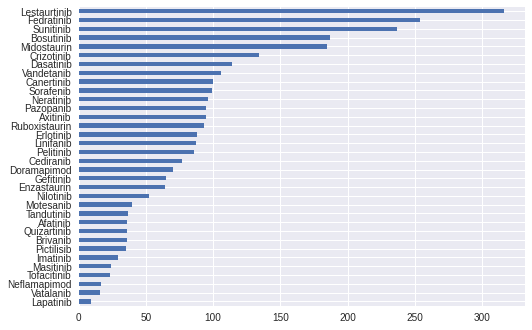

In [11]:
profiling_df.count().sort_values().plot(kind="barh");

## Ligands' on-targets dataset

__Criteria__: 

- Filters out ligands that are not available in the PKIDB or have no targets in the PKIDB.
- Filters out targets whose names cannot be mapped onto KinMap names

In [12]:
pd.set_option("max_colwidth", 100)
ligand_names = profiling_df.columns
ligand_targets = data.targets.pkidb(ligand_names, fda_approved=False)
ligand_targets

Changed kinase names (unknown names may be discarded - see function docstring):
    kinase.input            kinase.kinmap
0            nan  unknown (not in KinMap)
3          EPHA2                    EphA2
5           YES1                      YES
7         PDGFRB                   PDGFRb
17         NTRK1                     TRKA
18         CSF1R                      FMS
19        PDGFRA                   PDGFRa
22        PDGFRB                   PDGFRb
24         ERBB2                    ErbB2
30        PDGFRB                   PDGFRb
35        MAPK14                     p38a
36         VEGFA  unknown (not in KinMap)
38          PTK6                      BRK
39           TEK                     TIE2
41        PDGFRB                   PDGFRb
47         CSF1R                      FMS
48        PDGFRA                   PDGFRa
50         NR1I2  unknown (not in KinMap)
52         PDGFD  unknown (not in KinMap)
53           nan  unknown (not in KinMap)
56         ERBB2                    Er

,ligand.input,targets.pkidb,targets.kinmap
0,Lestaurtinib,[FLT3],[FLT3]
1,Tandutinib,[FLT3],[FLT3]
2,Brivanib,[KDR],[KDR]
3,Canertinib,[EGFR],[EGFR]
4,Cediranib,[KDR],[KDR]
5,Doramapimod,[MAPK14],[p38a]
6,Erlotinib,[EGFR],[EGFR]
7,Gefitinib,[EGFR],[EGFR]
8,Neflamapimod,[MAPK14],[p38a]
9,Crizotinib,"[ALK, MET]","[ALK, MET]"


### Ligand-kinase datasets

We merge now profiling and kinase similarity information into one dataset per ligand-kinase pair (_ligand-kinase dataset_). 

We only keep ligand-kinase pairs that
- have a minimum of `MIN_N_SHARED_KINASES` shared kinases
- have a minimum of `MIN_N_SHARED_ACTIVE_KINASES` shared active kinases, while activity is defined <= `KINASE_ACTIVITY_CUTOFF`

Select ligand-kinase pairs with enough coverage.

In [13]:
ligand_kinase_pairs = (
    ligand_targets[["ligand.input", "targets.kinmap"]]
    .explode("targets.kinmap")
    .to_numpy()
    .tolist()
)

## Evaluation metrics

In [14]:
evaluator = evaluation.LigandVsKinaseEvaluator(
    ligand_kinase_pairs,
    LIGAND_PROFILING_METHOD,
    KINASE_DISTANCES_METHOD,
    KINASE_ACTIVITY_CUTOFF,
    KINASE_ACTIVITY_MAX,
    MIN_N_SHARED_KINASES,
    MIN_N_SHARED_ACTIVE_KINASES,
)

Changed ligand names (unknown names may be discarded - see function docstring):
           ligand.input            ligand.pkidb
0         Staurosporine  unknown (not in PKIDB)
1           JNJ-7706621  unknown (not in PKIDB)
2              MLN-8054  unknown (not in PKIDB)
3               PKC-412             Midostaurin
4              SU-14813  unknown (not in PKIDB)
5             SB-202190  unknown (not in PKIDB)
6             CP-724714  unknown (not in PKIDB)
7        VX-680/MK-0457  unknown (not in PKIDB)
9   Roscovitine/CYC-202  unknown (not in PKIDB)
10            SB-203580  unknown (not in PKIDB)
12            CP-690550             Tofacitinib
14              GW-2580  unknown (not in PKIDB)
16            GW-786034  unknown (not in PKIDB)
18               VX-745            Neflamapimod
19            SB-431542  unknown (not in PKIDB)
20              ZD-6474              Vandetanib
22         Flavopiridol  unknown (not in PKIDB)
24              MLN-518              Tandutinib
25      

In [15]:
print(f"Number of pairs: {len(evaluator.ligand_kinase_pairs)}")
print(f"Number of ligands: {len(set([i[0] for i in evaluator.ligand_kinase_pairs]))}")

Number of pairs: 112
Number of ligands: 30


### Ligand types

In [16]:
pkidb = data.ligands.pkidb()
ligands = pkidb.set_index("ID")["Type"][list(evaluator.data_dict.keys())].reset_index()
ligands

,ID,Type
0,Brivanib,nan
1,Canertinib,nan
2,Cediranib,nan
3,Doramapimod,2
4,Erlotinib,1.5
5,Gefitinib,1.5
6,Neflamapimod,nan
7,Crizotinib,1
8,Pelitinib,1
9,Nilotinib,2


### Enrichment

#### Enrichment factor 

An enrichment factor is calculated as follows:

$EF_{x\%} = \frac{\frac{n_s}{n}}{\frac{N_s}{N}}$

with

- $N$   : Number of kinases in total
- $N_s$ : Number of kinases in top x% of ranked kinases
- $n$   : Number of active kinases in total
- $n_s$ : Number of active kinases in top x% of ranked kinases

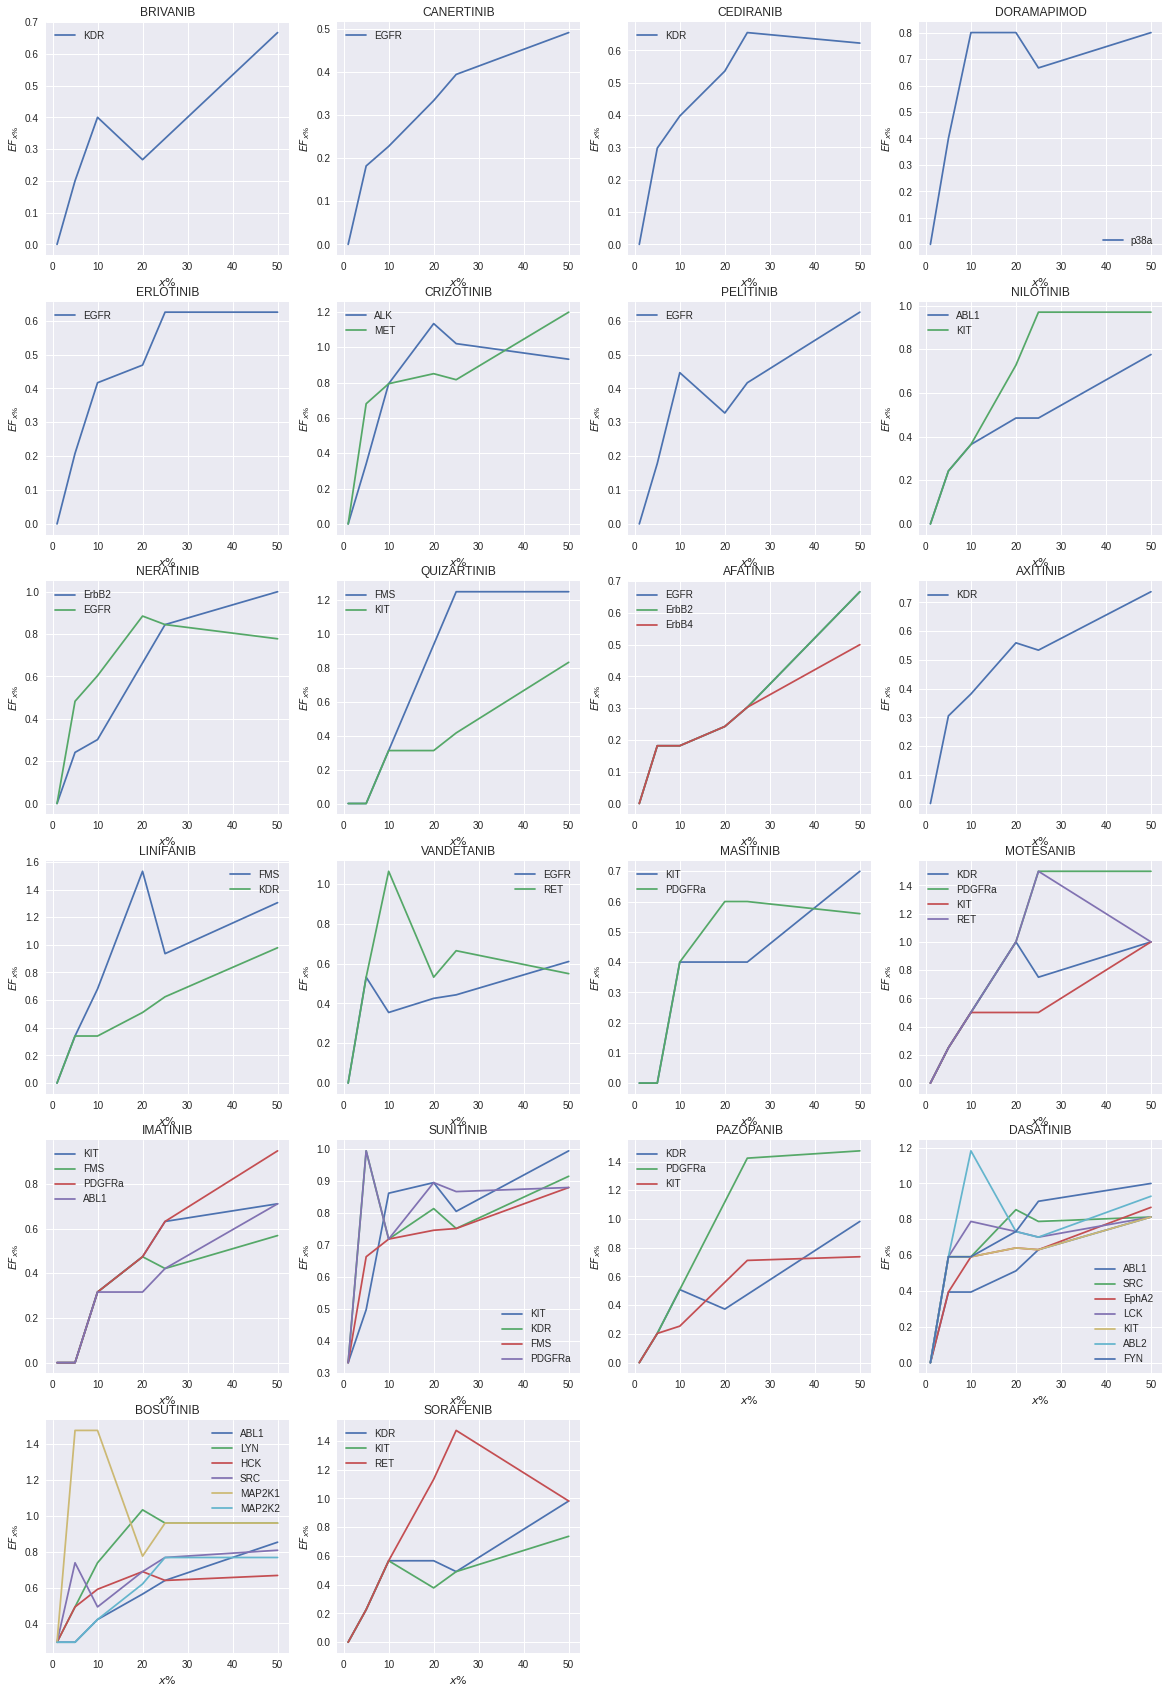

In [17]:
evaluator.plot_enrichment_factors()

#### Enrichment plots

For an enrichment plot, the x and y values are calculated as follows:

$x = \frac{N_s}{N}$, $y = \frac{n_s}{n}$

with

- $N$   : Number of kinases in total
- $N_s$ : Number of kinases in top x% of ranked kinases
- $n$   : Number of active kinases in total
- $n_s$ : Number of active kinases in top x% of ranked kinases

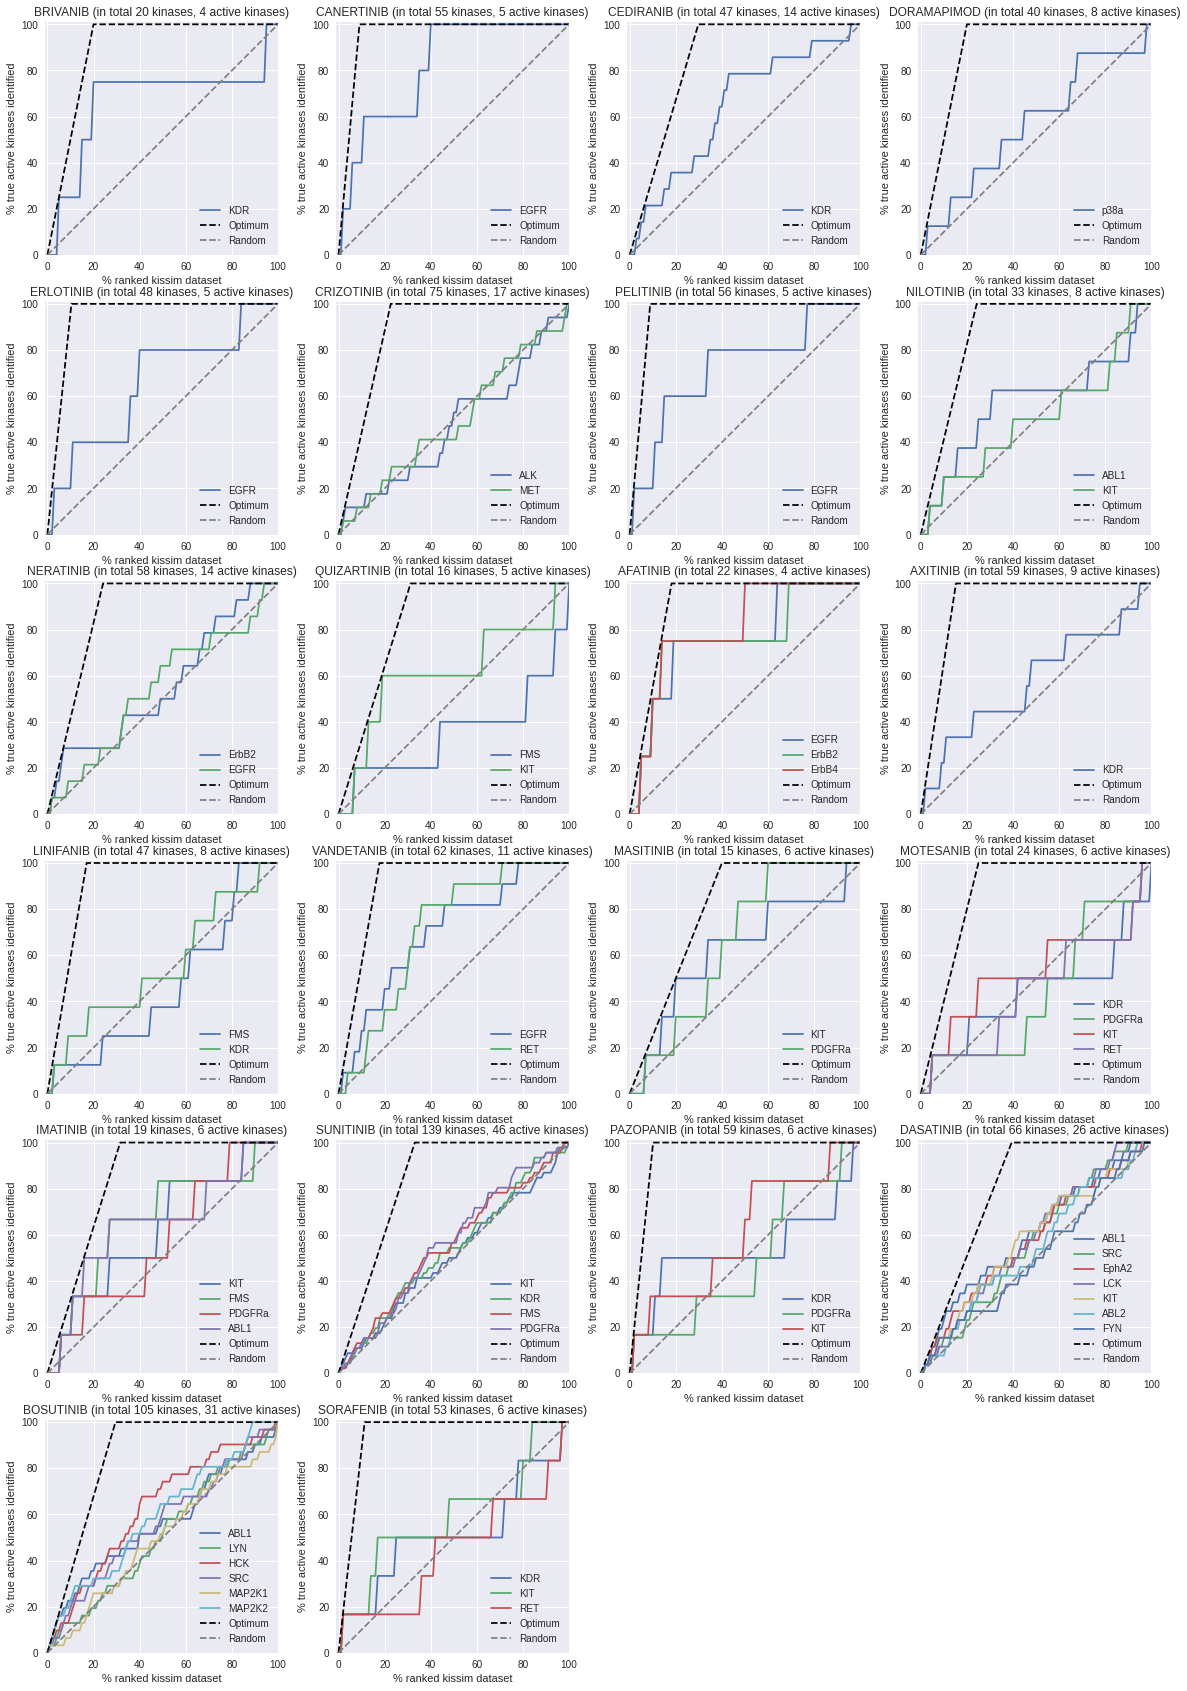

In [18]:
evaluator.plot_enrichment()

### ROC curves

- $TPR = \frac{TP}{P} = \frac{TP}{TP + FN}$
- $FPR = \frac{FP}{N} = \frac{FP}{FP + TN}$

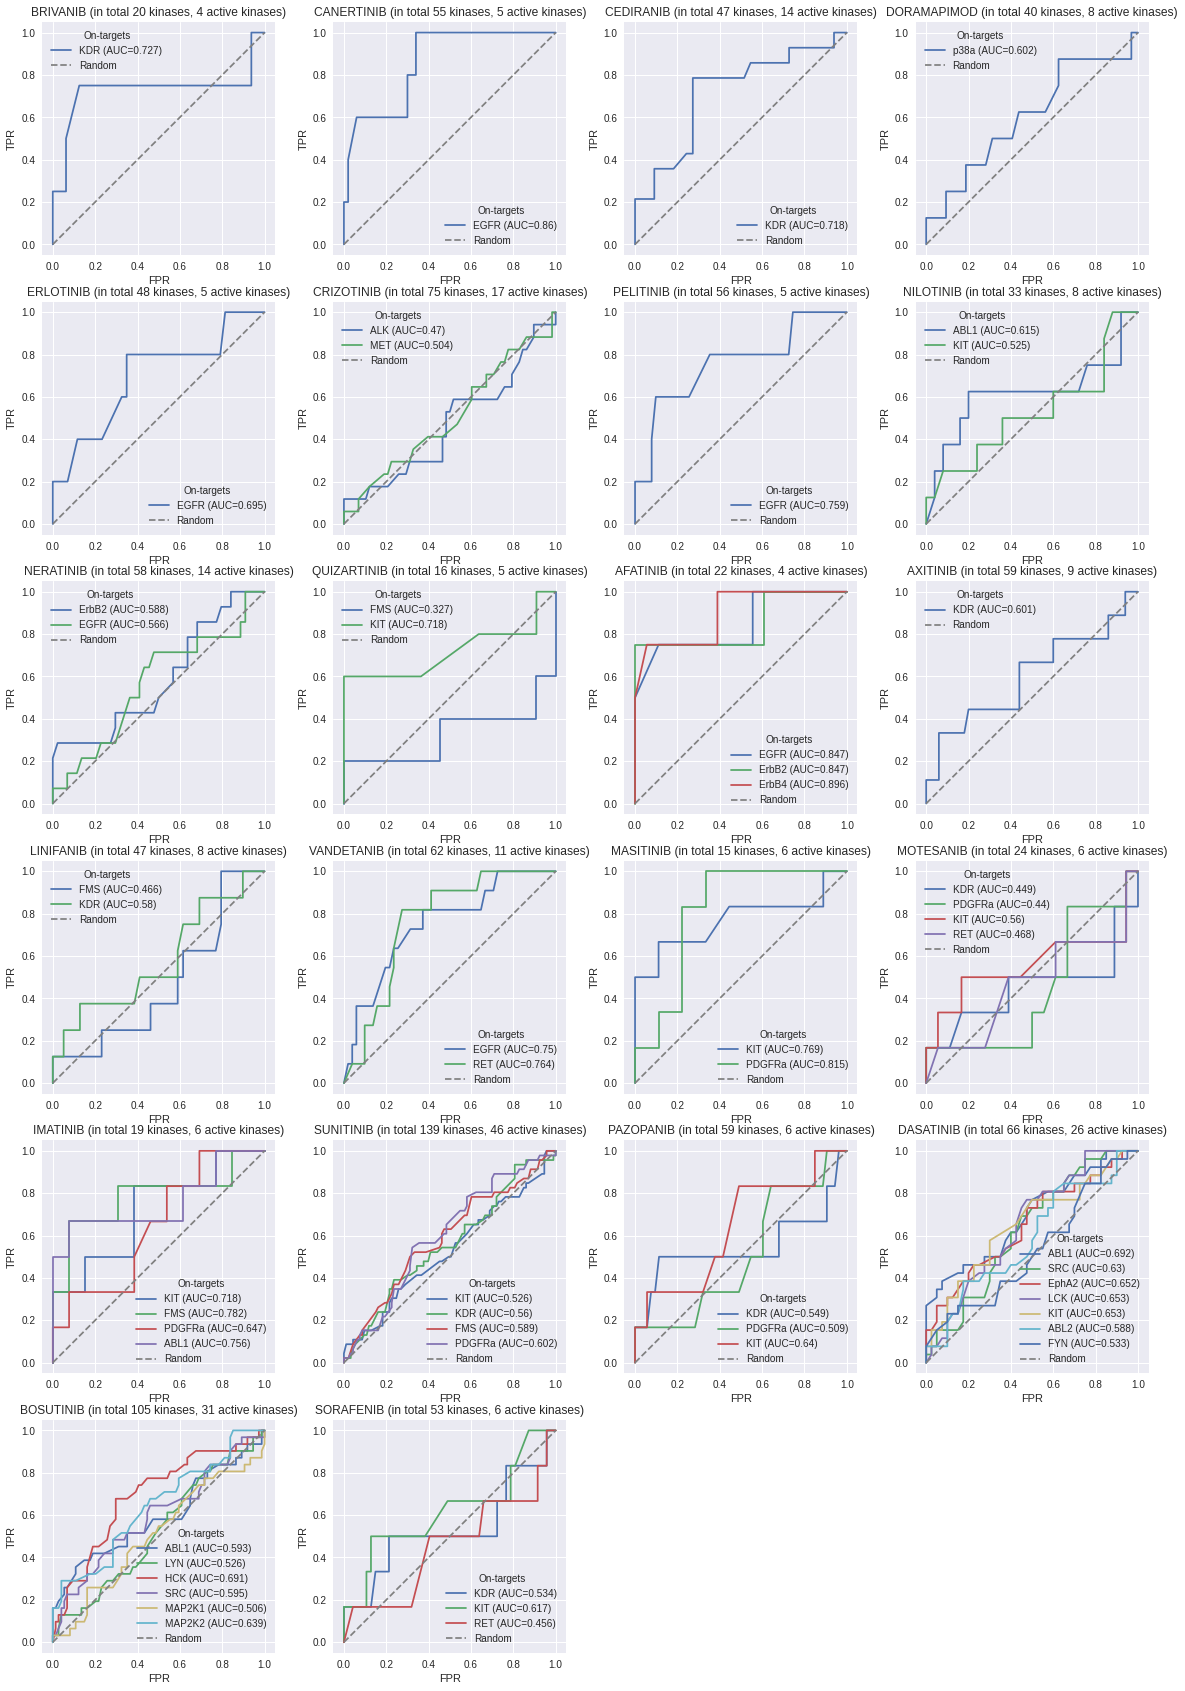

In [19]:
auc_list = evaluator.plot_roc_curves(
    HERE / "../../notebooks/figures/figX_profiling_roc_dfg_in_ifp.pdf"
);

In [20]:
print(f"Number of pairs: {len(auc_list)}")

Number of pairs: 55


In [21]:
np.mean(auc_list)

0.6247568998818097

In [22]:
np.std(auc_list)

0.12094618324274072

#### Selected ligand ROC curves

In [23]:
selected_ligands = ["Erlotinib", "Imatinib", "Bosutinib", "Doramapimod"]

In [24]:
# Select pairs based on selected ligands (in given order!!)
# Looks a bit complicated but necessary to keep ligand order!
ligand_kinase_pairs_df = pd.DataFrame(ligand_kinase_pairs, columns=["ligand", "kinase"])
ligand_kinase_pairs_selected = []
for selected_ligand in selected_ligands:
    ligand_kinase_pairs_selected.append(
        ligand_kinase_pairs_df.groupby("ligand").get_group(selected_ligand)
    )
ligand_kinase_pairs_selected = pd.concat(ligand_kinase_pairs_selected).values.tolist()

In [31]:
evaluator_selected = evaluation.LigandVsKinaseEvaluator(
    ligand_kinase_pairs_selected,
    LIGAND_PROFILING_METHOD,
    KINASE_DISTANCES_METHOD,
    KINASE_ACTIVITY_CUTOFF,
    KINASE_ACTIVITY_MAX,
    MIN_N_SHARED_KINASES,
    MIN_N_SHARED_ACTIVE_KINASES,
)

           ligand.input            ligand.pkidb
0         Staurosporine  unknown (not in PKIDB)
1           JNJ-7706621  unknown (not in PKIDB)
2              MLN-8054  unknown (not in PKIDB)
3               PKC-412             Midostaurin
4              SU-14813  unknown (not in PKIDB)
5             SB-202190  unknown (not in PKIDB)
6             CP-724714  unknown (not in PKIDB)
7        VX-680/MK-0457  unknown (not in PKIDB)
9   Roscovitine/CYC-202  unknown (not in PKIDB)
10            SB-203580  unknown (not in PKIDB)
12            CP-690550             Tofacitinib
14              GW-2580  unknown (not in PKIDB)
16            GW-786034  unknown (not in PKIDB)
18               VX-745            Neflamapimod
19            SB-431542  unknown (not in PKIDB)
20              ZD-6474              Vandetanib
22         Flavopiridol  unknown (not in PKIDB)
24              MLN-518              Tandutinib
25            LY-333531           Ruboxistaurin
26              CI-1033              Can

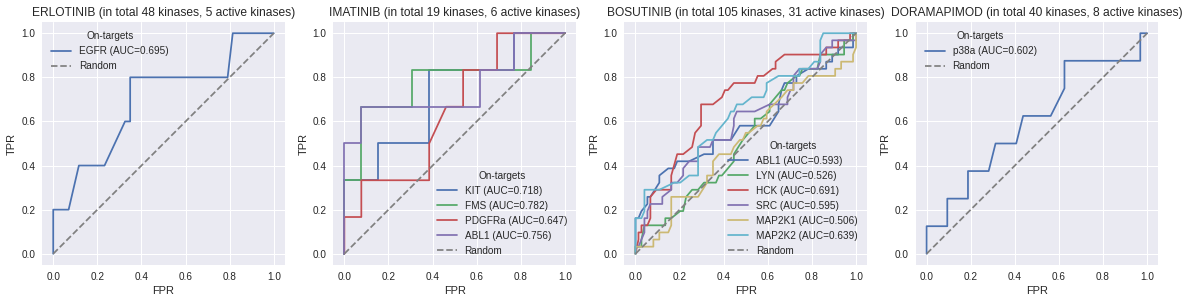

In [35]:
evaluator_selected.plot_roc_curves(
    HERE / "../../notebooks/figures/fig7_profiling_roc_dfg_in_selected_ifp.pdf"
);

### In detail: Look at ranks!

In [27]:
from opencadd.databases.klifs import setup_remote

In [28]:
def show_ranking(evaluator, kinase, ligand):
    session = setup_remote()
    ranking = evaluator.data_dict[ligand][kinase].data
    kinase_groups = session.kinases.by_kinase_name(ranking.index.to_list(), species="Human")[
        ["kinase.klifs_name", "kinase.group"]
    ].set_index("kinase.klifs_name")
    ranking = pd.merge(ranking, kinase_groups, left_index=True, right_index=True)
    return ranking

In [29]:
pairs = [
    ["EGFR", "Erlotinib"],
    ["ABL1", "Imatinib"],
    ["ABL1", "Bosutinib"],
    ["p38a", "Doramapimod"],
]

In [40]:
show_ranking(evaluator, "EGFR", "Erlotinib")

,karaman-davis.measure,karaman-davis.active,karaman-davis.rank1,karaman-davis.rank2,klifs-pocket-ifp.measure,klifs-pocket-ifp.rank1,klifs-pocket-ifp.rank2,kinase.group
EGFR,0.67,True,1.0,1.0,0.000000,2.0,1.0,TK
MER,980.00,False,30.0,15.0,0.055556,4.0,2.0,TK
AurA,2200.00,False,57.0,31.5,0.105263,15.5,3.0,Other
ErbB4,230.00,False,10.0,7.0,0.107143,17.0,4.0,TK
GAK,3.10,True,2.0,2.0,0.111111,20.5,6.0,Other
DYRK2,1300.00,False,41.5,23.0,0.111111,20.5,6.0,CMGC
SRC,700.00,False,21.0,13.0,0.111111,20.5,6.0,TK
JNK3,4300.00,False,76.0,41.0,0.125000,27.5,8.0,CMGC
CK1d,3500.00,False,70.0,37.0,0.142857,31.0,10.0,CK1
EphB4,2200.00,False,57.0,31.5,0.142857,31.0,10.0,TK


In [30]:
for kinase, ligand in pairs:
    display(Markdown(f"#### {ligand}"))
    ranks = show_ranking(evaluator_selected, kinase, ligand)
    display(HTML(ranks.to_html()))
    display(HTML(ranks[ranks["karaman-davis.active"]].to_html()))

#### Erlotinib

,karaman-davis.measure,karaman-davis.active,karaman-davis.rank1,karaman-davis.rank2,klifs-pocket-ifp.measure,klifs-pocket-ifp.rank1,klifs-pocket-ifp.rank2,kinase.group
EGFR,0.67,True,1.0,1.0,0.000000,2.0,1.0,TK
MER,980.00,False,30.0,15.0,0.055556,4.0,2.0,TK
AurA,2200.00,False,57.0,31.5,0.105263,15.5,3.0,Other
ErbB4,230.00,False,10.0,7.0,0.107143,17.0,4.0,TK
GAK,3.10,True,2.0,2.0,0.111111,20.5,6.0,Other
DYRK2,1300.00,False,41.5,23.0,0.111111,20.5,6.0,CMGC
SRC,700.00,False,21.0,13.0,0.111111,20.5,6.0,TK
JNK3,4300.00,False,76.0,41.0,0.125000,27.5,8.0,CMGC
CK1d,3500.00,False,70.0,37.0,0.142857,31.0,10.0,CK1
EphB4,2200.00,False,57.0,31.5,0.142857,31.0,10.0,TK


,karaman-davis.measure,karaman-davis.active,karaman-davis.rank1,karaman-davis.rank2,klifs-pocket-ifp.measure,klifs-pocket-ifp.rank1,klifs-pocket-ifp.rank2,kinase.group
EGFR,0.67,True,1.0,1.0,0.000000,2.0,1.0,TK
GAK,3.10,True,2.0,2.0,0.111111,20.5,6.0,Other
LOK,19.00,True,3.0,3.0,0.166667,54.5,15.0,STE
ABL1,76.00,True,6.0,5.0,0.181818,71.0,19.0,TK
SLK,26.00,True,5.0,4.0,0.263158,143.5,39.5,STE


#### Imatinib

,karaman-davis.measure,karaman-davis.active,karaman-davis.rank1,karaman-davis.rank2,klifs-pocket-ifp.measure,klifs-pocket-ifp.rank1,klifs-pocket-ifp.rank2,kinase.group
ABL1,12.0,True,4.0,3.0,0.000000,2.0,1.0,TK
ABL2,10.0,True,2.0,1.0,0.043478,4.0,2.0,TK
LCK,40.0,True,9.0,6.0,0.136364,10.5,3.0,TK
FYN,3100.0,False,22.5,14.5,0.157895,14.0,4.0,TK
KIT,13.0,True,5.0,4.0,0.173913,20.0,5.0,TK
LYN,890.0,False,11.0,7.0,0.200000,33.5,6.0,TK
IRAK1,1200.0,False,14.0,9.0,0.260870,69.5,7.0,TKL
JNK3,3100.0,False,22.5,14.5,0.291667,90.5,8.0,CMGC
MELK,1900.0,False,18.0,11.0,0.296296,96.0,9.0,CAMK
CLK1,4500.0,False,25.0,17.0,0.304348,100.0,10.5,CMGC


,karaman-davis.measure,karaman-davis.active,karaman-davis.rank1,karaman-davis.rank2,klifs-pocket-ifp.measure,klifs-pocket-ifp.rank1,klifs-pocket-ifp.rank2,kinase.group
ABL1,12.0,True,4.0,3.0,0.000000,2.0,1.0,TK
ABL2,10.0,True,2.0,1.0,0.043478,4.0,2.0,TK
LCK,40.0,True,9.0,6.0,0.136364,10.5,3.0,TK
KIT,13.0,True,5.0,4.0,0.173913,20.0,5.0,TK
PDGFRa,31.0,True,8.0,5.0,0.318182,109.5,13.0,TK
FMS,11.0,True,3.0,2.0,0.375000,159.0,16.0,TK


#### Bosutinib

,karaman-davis.measure,karaman-davis.active,karaman-davis.rank1,karaman-davis.rank2,klifs-pocket-ifp.measure,klifs-pocket-ifp.rank1,klifs-pocket-ifp.rank2,kinase.group
ABL1,0.057,True,1.0,1.0,0.000000,2.0,1.5,TK
EphA2,18.000,True,31.5,19.0,0.000000,2.0,1.5,TK
ABL2,1.500,True,8.0,6.0,0.043478,4.0,3.0,TK
BTK,4.800,True,17.0,10.0,0.045455,5.0,4.0,TK
EphB4,9.200,True,26.0,15.0,0.090909,6.5,5.0,TK
RIPK2,3700.000,False,168.5,96.0,0.111111,9.0,6.0,TKL
LCK,0.590,True,3.0,2.0,0.136364,10.5,7.5,TK
ULK2,450.000,False,89.0,52.0,0.136364,10.5,7.5,Other
FYN,11.000,True,28.0,17.0,0.157895,14.0,10.0,TK
YANK1,1800.000,False,131.5,79.5,0.157895,14.0,10.0,AGC


,karaman-davis.measure,karaman-davis.active,karaman-davis.rank1,karaman-davis.rank2,klifs-pocket-ifp.measure,klifs-pocket-ifp.rank1,klifs-pocket-ifp.rank2,kinase.group
ABL1,0.057,True,1.0,1.0,0.000000,2.0,1.5,TK
EphA2,18.000,True,31.5,19.0,0.000000,2.0,1.5,TK
ABL2,1.500,True,8.0,6.0,0.043478,4.0,3.0,TK
BTK,4.800,True,17.0,10.0,0.045455,5.0,4.0,TK
EphB4,9.200,True,26.0,15.0,0.090909,6.5,5.0,TK
LCK,0.590,True,3.0,2.0,0.136364,10.5,7.5,TK
FYN,11.000,True,28.0,17.0,0.157895,14.0,10.0,TK
SRC,1.000,True,5.0,4.0,0.160000,17.0,12.0,TK
EphA3,5.800,True,19.0,12.0,0.181818,24.5,16.0,TK
EGFR,35.000,True,43.0,26.0,0.181818,24.5,16.0,TK


#### Doramapimod

,karaman-davis.measure,karaman-davis.active,karaman-davis.rank1,karaman-davis.rank2,klifs-pocket-ifp.measure,klifs-pocket-ifp.rank1,klifs-pocket-ifp.rank2,kinase.group
p38a,0.45,True,1.0,1.0,0.000000,1.0,1.0,CMGC
KDR,3900.00,False,57.0,32.0,0.043478,2.0,2.0,TK
JNK3,110.00,False,12.0,9.0,0.095238,4.0,3.0,CMGC
EphA2,6200.00,False,62.0,36.0,0.100000,5.0,4.0,TK
p38b,7.20,True,4.0,3.0,0.120000,6.0,5.0,CMGC
LCK,1200.00,False,38.5,22.5,0.142857,8.0,6.0,TK
FGFR1,4300.00,False,58.0,33.0,0.160000,10.5,7.0,TK
EGFR,7000.00,False,64.0,37.0,0.173913,12.0,8.0,TK
HGK,90.00,True,11.0,8.0,0.200000,14.0,9.0,STE
TTK,3300.00,False,55.0,30.0,0.227273,21.5,10.5,Other


,karaman-davis.measure,karaman-davis.active,karaman-davis.rank1,karaman-davis.rank2,klifs-pocket-ifp.measure,klifs-pocket-ifp.rank1,klifs-pocket-ifp.rank2,kinase.group
p38a,0.45,True,1.0,1.0,0.000000,1.0,1.0,CMGC
p38b,7.20,True,4.0,3.0,0.120000,6.0,5.0,CMGC
HGK,90.00,True,11.0,8.0,0.200000,14.0,9.0,STE
p38d,78.00,True,10.0,7.0,0.240000,28.0,13.5,CMGC
LOK,12.00,True,7.0,5.0,0.272727,39.5,18.5,STE
JNK2,7.30,True,5.0,4.0,0.333333,80.0,25.0,CMGC
TIE2,20.00,True,8.0,6.0,0.344828,89.5,27.0,TK
p38g,2.90,True,3.0,2.0,0.545455,233.0,39.0,CMGC
